<center><h1>Quasi Vertical Profiles</h1>
*Scott Collis, Jonathan Helmus, Kirk North, Tim Lang, Kai Mühlbauer*
</center>


In [2]:
import pyart

import netCDF4
import numpy as np
import platform
from matplotlib import pyplot as plt, rc
from glob import glob
import os
from datetime import datetime, timedelta
from scipy import interpolate, stats
import fnmatch
import matplotlib.dates as mdates
from pytmatrix.tmatrix import TMatrix, Scatterer
from pytmatrix.tmatrix_psd import TMatrixPSD, GammaPSD
from pytmatrix import orientation, radar, tmatrix_aux, refractive
import pickle
from pytmatrix.psd import PSDIntegrator, GammaPSD
from matplotlib.colors import LogNorm
#import pydisdrometer

%matplotlib inline

In [3]:
my_system = platform.system()
if my_system == 'Darwin':
    top = '/data/sample_sapr_data/sgpstage/sur/'
    s_dir = '/data/sample_sapr_data/sgpstage/interp_sonde/'
    d_dir = '/data/agu2016/dis/'
    odir_r = '/data/agu2016/radars/'
    odir_s = '/data/agu2016/stats/'
    odir_i = '/data/agu2016/images/'
    p_dir = '/data/agu2016/pars/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/sgpstage/sur/'
    s_dir = '/lcrc/group/earthscience/radar/sgpstage/interp_sonde/'
    odir_r = '/lcrc/group/earthscience/radar/agu2016/radars/'
    odir_s = '/lcrc/group/earthscience/radar/agu2016/stats/'
    odir_i = '/lcrc/group/earthscience/radar/agu2016/images/'


In [133]:
def get_file_tree(start_dir, pattern):
    """
    Make a list of all files matching pattern
    above start_dir

    Parameters
    ----------
    start_dir : string
        base_directory

    pattern : string
        pattern to match. Use * for wildcard

    Returns
    -------
    files : list
        list of strings
    """

    files = []

    for dir, _, _ in os.walk(start_dir):
        files.extend(glob(os.path.join(dir, pattern)))
    return files

def find_closest(to_find, find_in):
    costfn = np.abs(find_in - to_find)
    locn = np.where(costfn == costfn.min())[0][0]
    return locn

def block_jumps(jumpy_array, jump_size ):
    delta_time =  np.diff(jumpy_array)
    jumps = np.where(delta_time > jump_size)[0]
    block_list = []
    #first jump
    block_list.append([0,jumps[0] + 1])
    for i in range(len(jumps)-1):
        block_list.append([jumps[i]+ 1,jumps[i+1] +1])
    block_list.append([jumps[-1],len(jumpy_array)])
    return block_list
        
    

In [134]:
a = np.linspace(0,100,100)
b = np.linspace(200,300,100)
c = np.linspace(400,450,50)

k = np.concatenate((a,b,c))
tst_blocks = block_jumps(k, 10)

In [135]:
print(tst_blocks)
for block in tst_blocks:
    print(k[block[0]:block[1]])

[[0, 100], [100, 200], [199, 250]]
[   0.            1.01010101    2.02020202    3.03030303    4.04040404
    5.05050505    6.06060606    7.07070707    8.08080808    9.09090909
   10.1010101    11.11111111   12.12121212   13.13131313   14.14141414
   15.15151515   16.16161616   17.17171717   18.18181818   19.19191919
   20.2020202    21.21212121   22.22222222   23.23232323   24.24242424
   25.25252525   26.26262626   27.27272727   28.28282828   29.29292929
   30.3030303    31.31313131   32.32323232   33.33333333   34.34343434
   35.35353535   36.36363636   37.37373737   38.38383838   39.39393939
   40.4040404    41.41414141   42.42424242   43.43434343   44.44444444
   45.45454545   46.46464646   47.47474747   48.48484848   49.49494949
   50.50505051   51.51515152   52.52525253   53.53535354   54.54545455
   55.55555556   56.56565657   57.57575758   58.58585859   59.5959596
   60.60606061   61.61616162   62.62626263   63.63636364   64.64646465
   65.65656566   66.66666667   67.67676768 

In [88]:
def masked_conv(string, bad_val = -9999.):
    try:
        out = float(string)
    except:
        out = bad_val
    
    return out

def proc_line(line):
    header = line.split(' ')[0]
    listme = [masked_conv(this_entry)\
               for this_entry in line.split(' ')[1:-1]]
    return header, np.array(listme)

def read_a_qvp(filename):
    fh = open(filename)
    all_lines = fh.readlines()
    fh.close()
    out = {}
    for line in all_lines:
        key, arrayme = proc_line(line)
        out.update({key : arrayme})
    form = 'csapr_qvp_%Y%m%d%H%M%S.txt'
    this_date = datetime.strptime(filename.split('/')[-1], form)
    return this_date, out

def concat_qvps(filelist):
    dateme, zero_entry = read_a_qvp(filelist[0])
    keys = zero_entry.keys()
    bucket = {}
    for key in keys:
        bucket.update({key: []})
    bucket.update({'date' : []})
    for filee in filelist:
        this_date, this_entry = read_a_qvp(filee)
        for key in this_entry.keys():
            bucket[key].append(this_entry[key])
        bucket['date'].append(this_date)
    height = this_entry['height(m)']
    qvp_th_series = {}
    for key in bucket.keys():
        if key != 'height(m)' and key != 'date':
            stacked = np.stack(bucket[key], axis=1)
            this_rec = {key: stacked}
            qvp_th_series.update(this_rec)
    qvp_th_series.update({'date' : np.array(bucket['date'])})
    qvp_th_series.update({'height' : zero_entry['height(m)']})
    return qvp_th_series
    

In [8]:
all_qvp_files = get_file_tree(odir_s, '*qvp*')
all_qvp_files.sort()


In [10]:
print(len(all_qvp_files))

3323


In [15]:
print(all_qvp_files[10])
fh = open(all_qvp_files[10])
all_lines = fh.readlines()
fh.close()

/data/agu2016/stats/20110423/csapr_qvp_20110423005920.txt


In [92]:
foo = concat_qvps(all_qvp_files)

In [152]:
foo_dates_second = netCDF4.date2num(foo['date'],  'seconds since 2011-04-23 00:59:20')
blocks = block_jumps(foo_dates_second, 40.0*60.0)
print(foo.keys())

dict_keys(['maesaka_differential_phase', 'cross_correlation_ratio', 'date', 'reflectivity', 'velocity_texture', 'height', 'corrected_specific_diff_phase', 'bringi_specific_diff_phase'])


In [138]:
print(blocks)

[[0, 492], [492, 985], [985, 1227], [1227, 1232], [1232, 1279], [1279, 1284], [1284, 1301], [1301, 1306], [1306, 1515], [1515, 1527], [1527, 1532], [1532, 1537], [1537, 1564], [1564, 1570], [1570, 1574], [1574, 1575], [1575, 1576], [1576, 1578], [1578, 1602], [1602, 1714], [1714, 1718], [1718, 1761], [1761, 1776], [1776, 1781], [1781, 1796], [1796, 1807], [1807, 1818], [1818, 1920], [1920, 1931], [1931, 1958], [1958, 1983], [1983, 1995], [1995, 2022], [2022, 2058], [2058, 2059], [2059, 2084], [2084, 2123], [2123, 2162], [2162, 2189], [2188, 3323]]


In [139]:
print(foo['date'].shape)
print(foo['reflectivity'].shape)
print(foo['height'].shape)



(3323,)
(61, 3323)
(61,)


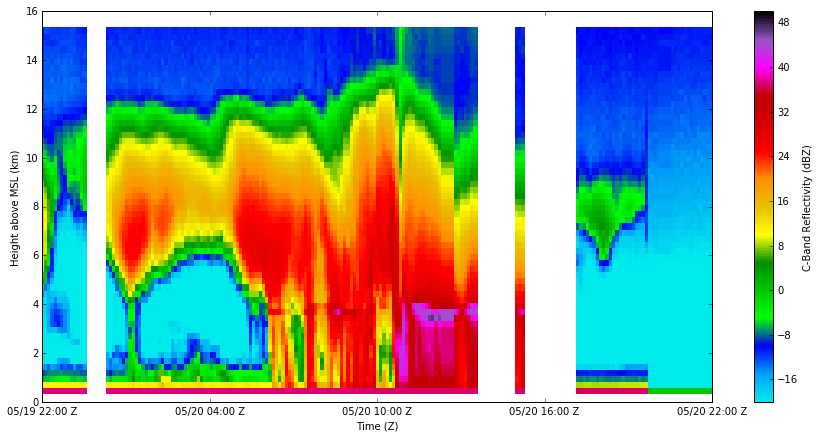

In [150]:
time1=mdates.datestr2num('20110519 2200')
time2=mdates.datestr2num('20110520 2200')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 6)
tFmt = mdates.DateFormatter('%m/%d %H:%M Z')

fig = plt.figure(figsize=[15,7])
for block in blocks:
    plt.pcolormesh(mdates.date2num(foo['date'])[block[0]:block[1]], 
                   foo['height']/1000.0, foo['reflectivity'][:,block[0]:block[1]],
                  vmin = -20, vmax = 50, cmap = pyart.graph.cm.NWSRef)
ax = plt.gca()
plt.ylabel('Height above MSL (km)')
plt.xlabel('Time (Z)')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])

plt.colorbar(label='C-Band Reflectivity (dBZ)')

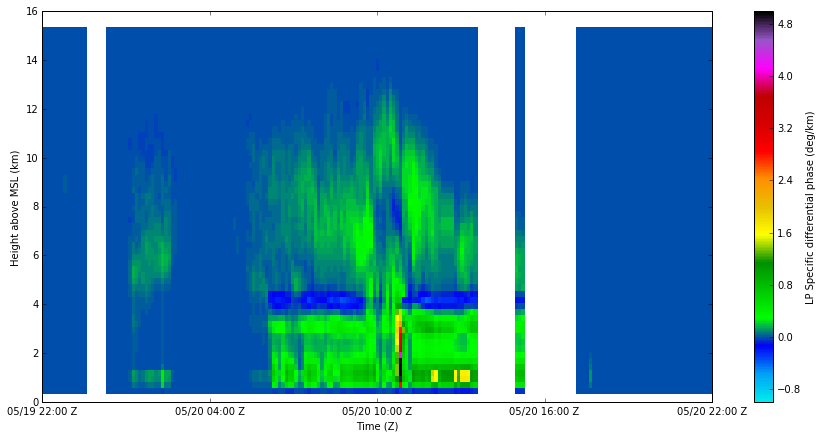

In [151]:
time1=mdates.datestr2num('20110519 2200')
time2=mdates.datestr2num('20110520 2200')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 6)
tFmt = mdates.DateFormatter('%m/%d %H:%M Z')

fig = plt.figure(figsize=[15,7])
for block in blocks:
    plt.pcolormesh(mdates.date2num(foo['date'])[block[0]:block[1]], 
                   foo['height']/1000.0, foo['corrected_specific_diff_phase'][:,block[0]:block[1]],
                  vmin = -1, vmax = 5, cmap = pyart.graph.cm.NWSRef)
ax = plt.gca()
plt.ylabel('Height above MSL (km)')
plt.xlabel('Time (Z)')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])

plt.colorbar(label='LP Specific differential phase (deg/km)')

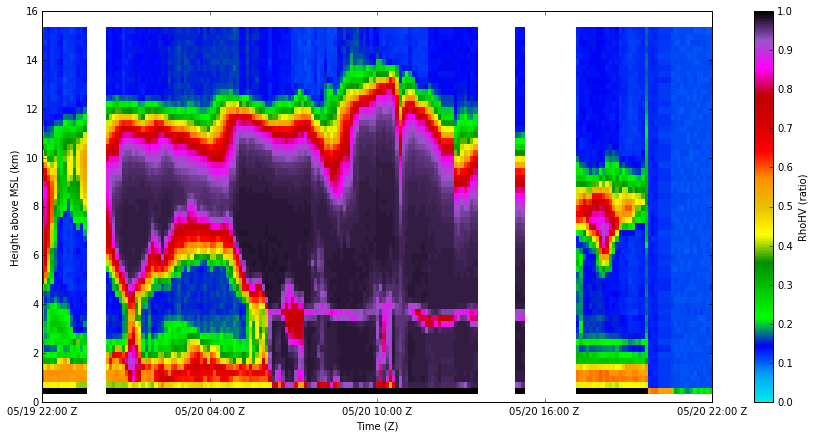

In [154]:
time1=mdates.datestr2num('20110519 2200')
time2=mdates.datestr2num('20110520 2200')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 6)
tFmt = mdates.DateFormatter('%m/%d %H:%M Z')

fig = plt.figure(figsize=[15,7])
for block in blocks:
    plt.pcolormesh(mdates.date2num(foo['date'])[block[0]:block[1]], 
                   foo['height']/1000.0, foo['cross_correlation_ratio'][:,block[0]:block[1]],
                  vmin = 0, vmax = 1, cmap = pyart.graph.cm.NWSRef)
ax = plt.gca()
plt.ylabel('Height above MSL (km)')
plt.xlabel('Time (Z)')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])

plt.colorbar(label='RhoHV (ratio)')

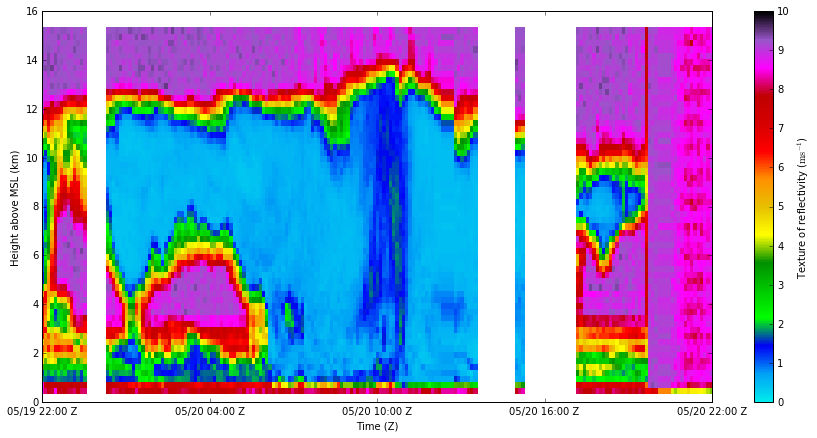

In [160]:
time1=mdates.datestr2num('20110519 2200')
time2=mdates.datestr2num('20110520 2200')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 6)
tFmt = mdates.DateFormatter('%m/%d %H:%M Z')

fig = plt.figure(figsize=[15,7])
for block in blocks:
    plt.pcolormesh(mdates.date2num(foo['date'])[block[0]:block[1]], 
                   foo['height']/1000.0, foo['velocity_texture'][:,block[0]:block[1]],
                  vmin = 0, vmax = 10, cmap = pyart.graph.cm.NWSRef)
ax = plt.gca()
plt.ylabel('Height above MSL (km)')
plt.xlabel('Time (Z)')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])

plt.colorbar(label=r'Texture of reflectivity ($\mathrm{ms^{-1}}$)')

In [87]:
plt.pcolormesh?

In [37]:
print(this_date)

2011-04-23 00:59:20


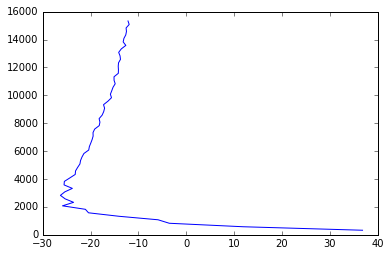

In [52]:
plt.plot(my_qvp['reflectivity'],my_qvp['height(m)'])

In [57]:
arrayme = np.array([0,1,2,3])
arrayme2 = np.array([5,1,2,3])
print(np.stack([arrayme,arrayme2], axis=1).shape)


(4, 2)
